Load libraries.

In [1]:

#!pip install scikit-learn
#!pip install matplotlib
#!pip install tabulate

Here is the implementation of the algorithm for the fetal ECG detection proposed in Paper 3. It will be shown step by step: we will declare functions while showing their role using just a single dataset entry as an example. We will also declare some constants that will be held until the end of the script. At the end of the script we will apply the algorithm on each dataset entry and we will evaluate the performance. The functions used for plotting are defined in the `plot_functions.py` file.

Let's first load the libraries and setup some global parameters.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
from scipy.fft import fft, ifft
import scipy.signal as signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, max_error
from numpy.linalg import eig
from plot_functions import plot_signal, plot_signal_annotations, plot_error_timeline, plot_fhr_trace

# Choose the first one of the two dataset (entry from a01 to a25)
# The second one contains entries from a26 to a75 and is in the folder:
# "./data/set-a-ext-text/"
DATA_FOLDER = "./data/set-a-text/"
# This is the dataset entry that we will use as an example.
# n°1 is a poor entry while n°5 gives a high performance
EXAMPLE_N = 5

# Sampling frequency of the dataset
Fs = 1000 


PLOT_WIDTH = 10

Now we define a function to load our example dataset entry. It is composed of 4 ECGs with the corresponding annotations (fs=1000Hz).

In [3]:
def load_dataset_entry(id):
    '''
    This function will load a dataset entry:
    Input: the ID of the entry (starting at 1)
    Output: the 4 ecgs (as a numpy 4 dimensional array) and a 1D array containing the fetal ECG annotations
    '''
    id_string = str(id)
    if id < 10:
        id_string = "0" + id_string
    ecg_csv_path = DATA_FOLDER + "a" + id_string + ".csv"
    ecg_annotations_path = DATA_FOLDER + "a" + id_string + ".fqrs.txt"
    ecgs = np.genfromtxt(ecg_csv_path,delimiter=",")
    fecg_annot = np.loadtxt(ecg_annotations_path).astype(int)
    ecgs = ecgs.transpose()
    # Remove the first two entries of every line (header and measure unit)
    ecgs = np.delete(ecgs, [0,1], 1)
    # Remove the first row signal (it contains only timestamps)
    ecgs = np.delete(ecgs, 0, 0)
    # Now ecgs contains 4 rows of ECGS
    return ecgs, fecg_annot

ecgs_raw, fecg_annot = load_dataset_entry(EXAMPLE_N)

Now we need to preprocess the signals. We will apply the preprocessing to each of the 4 signals individually. First, we need a function to interpolate, because some signals in the dataset contains NaNs. After that, we can start the preprocessing phase. As an example, we consider only the first ECG signal of the dataset entry. We first check for NaNs and then we plot it with the annotations of the fetal ECG.

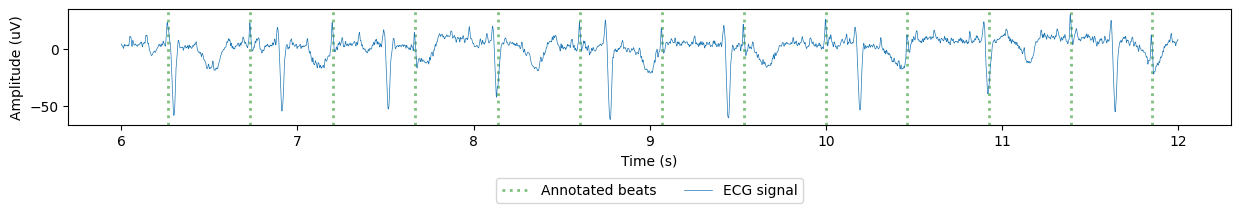

In [4]:
# This function will substitute NaN with interpolated values
def interpolate_nan_values(sig):
  '''
  This function will interpolate NaN values in the signal:
  Input: the signal
  Output: the interpolated signal
  '''
  result = sig.copy()
  if np.isnan(sig).any():
    nan_indexes = np.isnan(sig) # bool array where indices of nan values are True
    valid_indexes = ~nan_indexes # bool array where indices of correct values are True
    valid_signal = sig[valid_indexes] # signal without nan values
    result = np.interp(np.array(range(0,len(sig))), valid_indexes.nonzero()[0], valid_signal)
  return result

# Select the first of the 4 ECGs, then interpolate it and plot it
sig_raw = ecgs_raw[0]
sig = interpolate_nan_values(sig_raw)
plot_signal_annotations(sig,[],Fs,1,10,ground_truth=fecg_annot)

The first step of the preprocessing requires to filter out the baseline wonder. To visualize the result more clearly, we first add a fake baseline wonder to the signal. After that we define a function that filters the signal with a high-pass filter with cut-off frequency at fc = 3Hz (given that we are now doing offline processing, we can use the filtfilt function to avoid delays). After that, we plot the result.

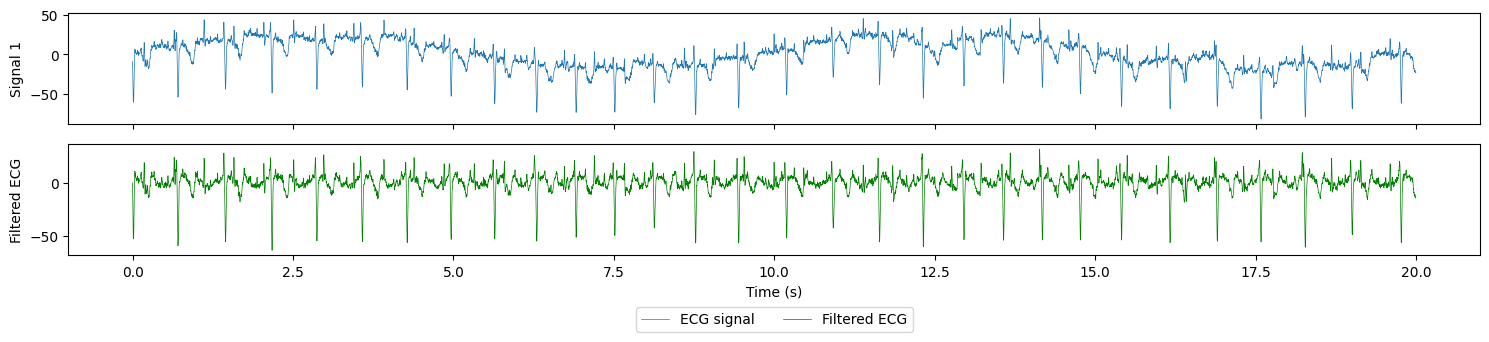

In [5]:
# We add a fake baseline wonder
bw_f = 0.1 #Hz
bw_frel = bw_f / Fs
n = np.array(range(0,len(sig)))
bw = np.sin(2 * math.pi * bw_frel * n)*20
sig = sig + bw

# Calculate filter coefficients and store them as a constant
HP_TAPS = 1001 # N of taps
HP_Fc = 3 # Filter cut off (Hz)
HP_FILTER_COEFF = signal.firwin(HP_TAPS, HP_Fc/(Fs/2), pass_zero="highpass")

# This function will do the high pass filtering
def apply_hp_filter(sig,coefficients):
  '''
  This function will apply the high pass FIR filter to remove baseline wonder without adding delay:
  Input: the signal
  Output: the coefficients
  '''
  filtered_signal = signal.filtfilt(coefficients,1,sig)
  return filtered_signal

# Apply the filter and plot
filt_sig = apply_hp_filter(sig,HP_FILTER_COEFF)

plot_signal(np.array([sig,filt_sig]),Fs,0,3,different_sig=[[1],"green","Filtered ECG","Filtered ECG"])

Now we use a notch filter to remove the power line interference. As before, we add a fake power line interference to visualize the filter action. After that we filter the signal with a notch centered at f0 = 50 Hz and we plot the results.

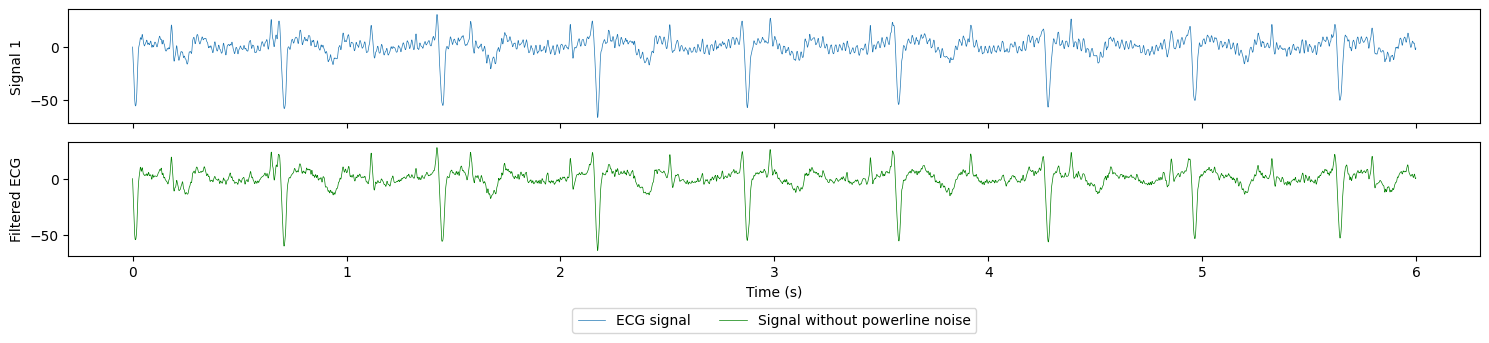

In [6]:
# Calculate filter coefficients and store them as constants
NOTCH_Fc = 50.0  # Frequency to be removed from signal (Hz)
NOTCH_Q = 30.0  # Quality factor
NOTCH_B, NOTCH_A = signal.iirnotch(NOTCH_Fc, NOTCH_Q, Fs) #numerator, denominator

# This function will do the notch filtering
def remove_power_line_noise(notch_num, notch_denom, sig):
  '''
  This function will apply a filter to remove the power line noise without adding delay:
  Input: the coefficient (numerator and denominator) and the signal
  Output: the filtered signal
  '''
  filtered_signal = signal.filtfilt(notch_num, notch_denom, sig)
  return filtered_signal

# Add a fake powerline noise
pwln_f = 50 #Hz
pwln_frel = pwln_f / Fs
n = np.array(range(0,len(sig)))
pwln = np.sin(2 * math.pi * pwln_frel * n)*3
filt_sig = filt_sig + pwln

# Apply the filter and plot the signal
filt_n_sig = remove_power_line_noise(NOTCH_B, NOTCH_A, filt_sig)
plot_signal(np.array([filt_sig,filt_n_sig]),Fs,0,10,different_sig=[[1],"green","Signal without powerline noise","Filtered ECG"])

We now upsample the signal to UP_Fs = 2000Hz

In [7]:
UP_Fs = 2000 # Upsampling frequency
UP_LENGTH_OF_SIGNAL = int((len(filt_n_sig)/Fs) * UP_Fs)

def upsample_signal(sig,length):
  '''
  This function will upsample the signal:
  Input: the signal
  Output: the upsampled signal upscaled to the new length
  '''
  upsampled_signal = signal.resample(sig,length)
  return upsampled_signal

up_sig = upsample_signal(filt_n_sig,UP_LENGTH_OF_SIGNAL)

Up to now, we have shown the preprocessing phase on a single signal. We now consider again all the 4 ECG signals together. First we create a function that groups the previous preprocessing actions (we also need to upscale the annotations to match the new Fs and the filter delay). After that, we reload the 4 ECG signals of a single dataset entry. We then preprocess and plot them.

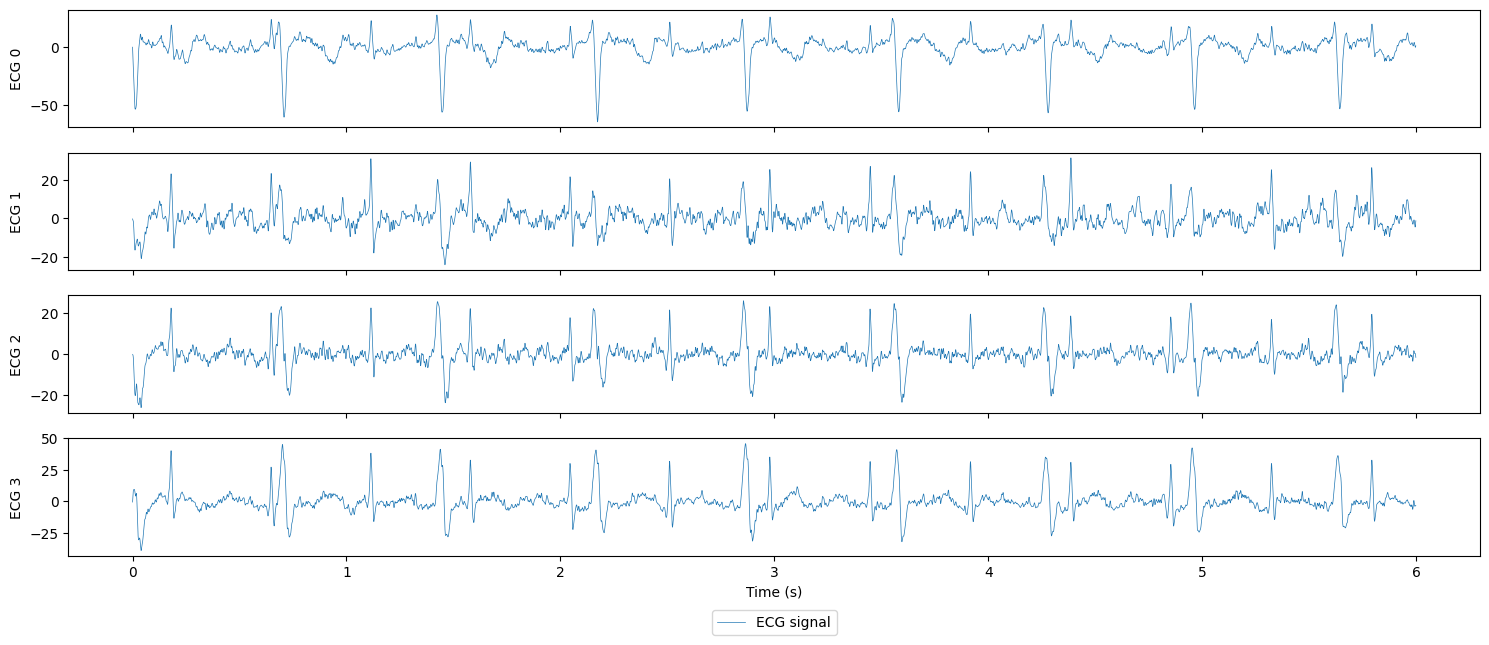

In [8]:

def preprocess_signals(ecg_signals,annotations):
  '''
  This function will do all the preprocessing:
  Input: the 4 ECGS and the annotations
  Output: the 4 processed ECGS and the upscaled annotations
  '''
  processed_ecgs = []
  for s in ecg_signals:
    s = interpolate_nan_values(s)
    s = apply_hp_filter(s,HP_FILTER_COEFF)
    s = remove_power_line_noise(NOTCH_B, NOTCH_A, s)
    s = upsample_signal(s,UP_LENGTH_OF_SIGNAL)
    processed_ecgs.append(s)
  # Rescale and shift the fetus beats annotation to match the new fs
  scaled_annotations = np.array(annotations * (UP_Fs/Fs), dtype=int)
  return [np.array(processed_ecgs),scaled_annotations]

# We load the example dataset entry and we preprocess it
ecgs_raw, fecg_annot = load_dataset_entry(EXAMPLE_N)
ecgs, f_annot_scaled = preprocess_signals(ecgs_raw, fecg_annot)

# Plot
plot_signal(ecgs,UP_Fs,0,10,signals_labels=["ECG 0","ECG 1","ECG 2","ECG 3"])

Now we do the PCA on the 4 signals. First we calculate the covariance matrix and the eigenvectors/eigenvalues and then we return the first principal component.

In [9]:
def do_PCA(signals,plot=False):
    '''
    This function will apply the PCA:
    Input: the 4 ECGS
    Output: the first PCA component
    '''
    # Normalize the signals
    norm_signals = signals.copy()
    for r in range(0,signals.shape[0]):
        row_avg = np.average(signals[r])
        row_dev = np.std(signals[r])
        norm_signals[r] = signals[r] - row_avg
        norm_signals[r] = signals[r] / row_dev
    # Calculate covariance matrix
    cov_mat = np.cov(norm_signals)
    # Find eigenvalues/eigenvectors and put the biggest on top
    eigen_values , eigen_vectors = np.linalg.eig(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    # Exctract the first component
    num_components = 1
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
    result_of_PCA = np.dot(eigenvector_subset.transpose(), norm_signals)
    if plot:
        plot_signal(norm_signals,UP_Fs,0,10,signal_label="ECG signals")
        plot_signal(result_of_PCA,UP_Fs,0,10,signal_label="PCA result",line_color="red")
    return result_of_PCA[0]

PCA_first_component = do_PCA(ecgs,plot=False)

We now search the peaks in the first PCA component by using a mininum distance of 0.5 sec (120bpm)

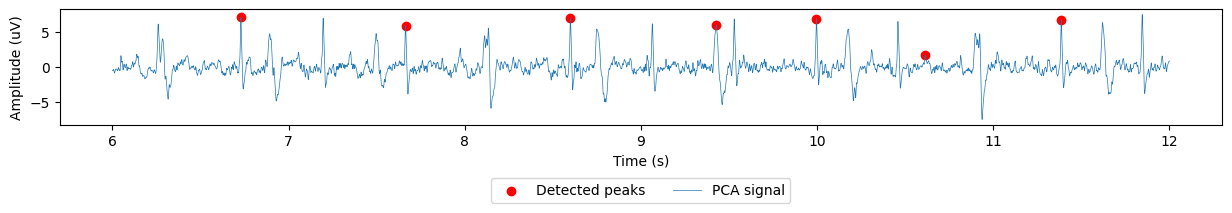

In [10]:
PEAKS_DISTANCE_MOTHER = 0.5 #sec

peaks, _ = signal.find_peaks(PCA_first_component,distance=PEAKS_DISTANCE_MOTHER*UP_Fs)
plot_signal_annotations(PCA_first_component,peaks,UP_Fs,1,10,signal_label="PCA signal",annotation_symbol=["o","red","Detected peaks"])

We now create a QRS template by averaging the signal sections (of length 100ms) centered on the peaks.

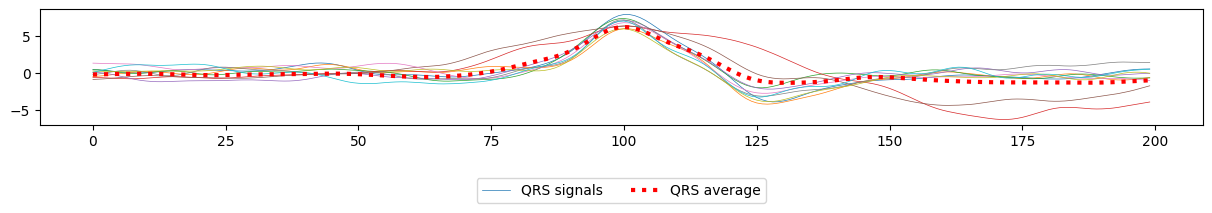

In [11]:
BEFORE_PEAK_MOTHER = 0.05 # 50ms
AFTER_PEAK_MOTHER = 0.05 # 50ms

def create_template(sig,peaks,fs,sec_before_peak,sec_after_peak,plot=False):
    '''
    This function will create a template of the QRS complex
    Input: the signal, the positions of the peaks, the sampling freq, the time before and after peaks (sec)
    Output: the template, the offset (relative to the center)
    '''
    offset = (((sec_before_peak + sec_after_peak) / 2) - sec_before_peak) * fs
    qrss = []
    for peak in peaks:
        if peak - int(sec_before_peak*UP_Fs) < 0 or peak + int(sec_after_peak*fs) > len(sig):
            continue
        qrs = sig[peak - int(sec_before_peak*UP_Fs): peak + int(sec_after_peak*fs)]
        qrss.append(qrs)
    qrss = qrss[1:]
    template = np.mean(qrss,axis=0)
    if plot:
        n_of_signals = len(peaks)-1
        if n_of_signals > 10:
            n_of_signals = 10
        for i in range(0,n_of_signals):
            if i==0:
                plt.plot(qrss[i],label="QRS signals")
            else:
                plt.plot(qrss[i])
        plt.plot(template,linewidth="3",linestyle="dotted",color="red",label="QRS average")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),fancybox=True, ncol=5)
        plt.show()
    return template, offset

qrs_template, qrs_offset = create_template(PCA_first_component,peaks,UP_Fs,BEFORE_PEAK_MOTHER,AFTER_PEAK_MOTHER,plot=True)

We now evaluate the correlation between the signal and the qrs template to find the beats positions in the signal (we group all the steps before in a single function).

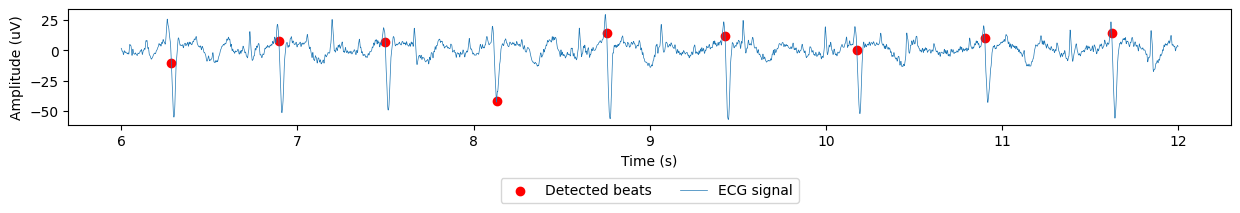

In [12]:
def qrs_detection(ecgs,fs,pk_dist,sec_before,sec_after):
    '''
    This function will do the QRS detection employing the correlation with a template
    Input: the 4 ecgs, the sampling freq, the minimum peak distance, the time before and after the peaks (sec)
    Output: the QRS peaks positions
    '''
    # Enhance the 4 signals with the PCA
    PCA_sig = do_PCA(ecgs)
    # Find the peaks
    peaks, _ = signal.find_peaks(PCA_sig,distance=pk_dist*fs)
    peaks = np.array(peaks)[1:-1] # remove extremes
    # Build the template averaging the peaks 
    template, offset = create_template(PCA_sig,peaks,fs,sec_before,sec_after)
    # Evaluate the correlation
    correlation = signal.correlate(PCA_sig, template, mode='same')
    # Find peaks on the correlation
    extracted_peaks, _ = signal.find_peaks(correlation,distance=fs*pk_dist)
    extracted_peaks = extracted_peaks - offset
    return extracted_peaks.astype(int)[1:]

mother_peaks = qrs_detection(ecgs,UP_Fs,PEAKS_DISTANCE_MOTHER,BEFORE_PEAK_MOTHER,AFTER_PEAK_MOTHER)
plot_signal_annotations(ecgs[0],mother_peaks,UP_Fs,1,10)

The mother_peaks array contains the detected peaks m. We now proceed to remove the maternal ECG from the signal by analizing each signal individually (and each peak individually). 
The steps are:
1. We consider the peak position m
2. We build the mecg_template (u) by averaging the Nth previous beats
3. We build the M matrix by windowing the mecg_template (u)
4. We calculate the scaling vector a = (M^T M)^-1 M^T * m
5. We calculate m hat
6. We subtract m hat from the signal at the position m
We repeat all of that for each peak m.

Let's make a visual example for the 13h beat of the first ECG signal. We first create a ecg template (u) of the maternal beat by averaging N=10 previous maternal QRS complexes using the function we built before.

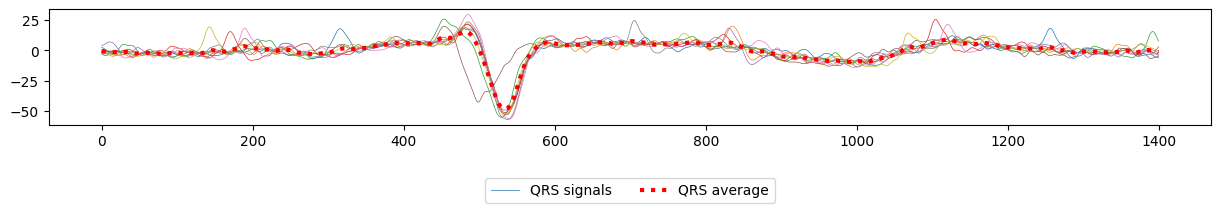

In [13]:
# Define the length of the p and t waves
P_WAVE = 0.25
T_WAVE = 0.45

# Takes only the first ECG and calculate the template for the 15th beat by averaging the N previous beats
single_ecg = ecgs[0]
example_beat = 15
mecg_template, _ = create_template(single_ecg,mother_peaks[example_beat-10:example_beat],UP_Fs,P_WAVE,T_WAVE,plot=True)

We then create the scaling matrix M: we build the u<sub>p</sub>, u<sub>r</sub> and u<sub>t</sub> vectors by windowing the template.

In [14]:
def create_M_matrix(template,fs,p_length,t_length):
    '''
    This function will create the matrix to scale the QRS template
    Input: the template, the sampling freq, the time before and after the peak (for P and T wave)
    Output: the scaling matrix
    '''
    p_samples = range(0,int((p_length - 0.05)*fs))
    r_samples = range(int((p_length - 0.05)*fs), len(template) - int((t_length - 0.05)*fs))
    t_samples = range(len(template) - int((t_length - 0.05)*fs),len(template))
    u_p = template[p_samples]
    u_r = template[r_samples]
    u_t = template[t_samples]
    M = np.zeros((3,len(template)))
    M[0][p_samples] = u_p
    M[1][r_samples] = u_r
    M[2][t_samples] = u_t
    M = M.transpose()
    return M

M = create_M_matrix(mecg_template,UP_Fs,P_WAVE,T_WAVE)

We now consider the beat m and we calculate the scaling factor (a) for the template. The MECG template (u) is then scaled by the a factor using the M matrix (obtaining m hat)

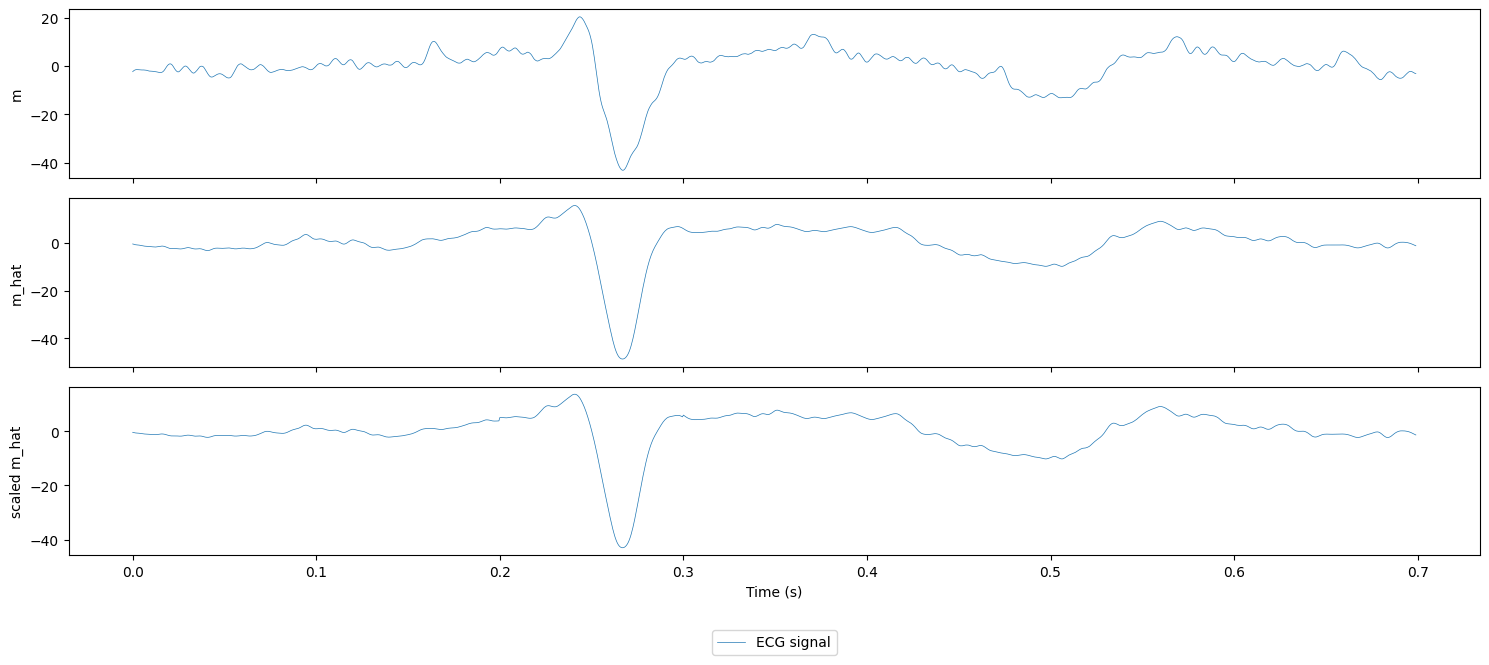

In [15]:
m = single_ecg[int(mother_peaks[example_beat]-P_WAVE*UP_Fs) : int(mother_peaks[example_beat]+T_WAVE*UP_Fs)]
a = np.matmul(np.linalg.pinv(M),m)
scaled_mecg_template = np.matmul(M,a)

plot_signal(np.array([m,mecg_template,scaled_mecg_template]),UP_Fs,signals_labels=["m","m_hat","scaled m_hat"],row_height=2)

We now define a function that does the MECG cancellation from all the signals contained in the ECG by averaging the N previous beats.

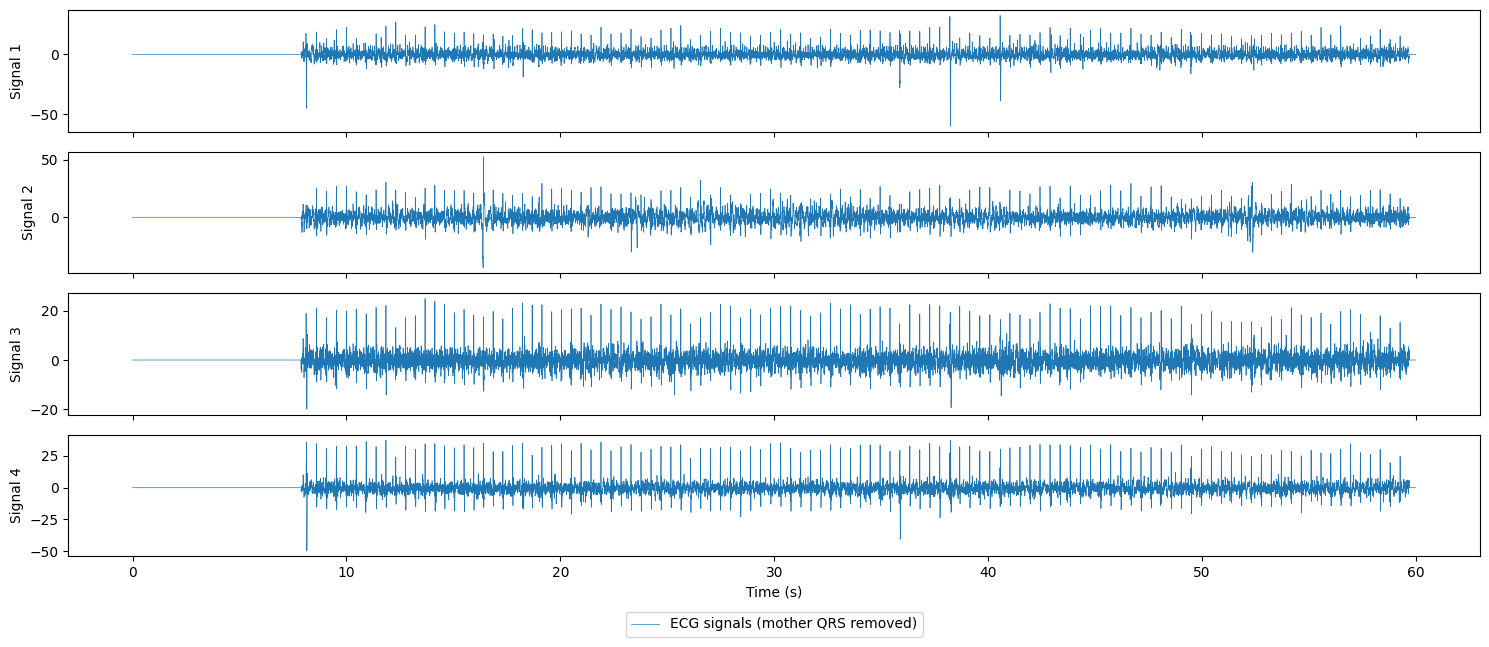

In [16]:
def mecg_removal(m_ecgs, peaks, N, fs, p_wave, t_wave):
    '''
    This function will remove the maternal ECG from the signal
    Input: the 4 ECGs, the peak positions, N (number of previous peaks for the averaging), sampling freq, time before and after peaks (P and T wave)
    Output: the 4 signals without the maternal beat, the template, the starting point of the algorithm
    '''
    f_ecgs_result = m_ecgs.copy()
    templ = []
    algo_start_point = 0
    algo_end_point = 0
    for i in range(0,f_ecgs_result.shape[0]):
        sig = f_ecgs_result[i]
        # consider only N beats ahead and remove the part before 
        result_signal = sig.copy()
        algo_start_point = int(peaks[N+1]-p_wave*fs)
        result_signal[0:algo_start_point] = np.zeros(algo_start_point)
        for n in range(N,len(peaks)-1):
            # Create template
            u, _ = create_template(sig,peaks[n-N:n],fs,p_wave,t_wave)
            templ.append(u)
            # Calculate scaling matrix
            M = create_M_matrix(u,fs,p_wave,t_wave)
            # Get m
            m_start = int(peaks[n+1]-p_wave*fs)
            m_end = int(peaks[n+1]+t_wave*fs)
            if m_end > len(sig):
                # if the template is outside the signal
                break
            m = sig[m_start : m_end]
            # Calculate scaling vector a
            a = np.matmul(np.linalg.pinv(M),m)
            # Scale the template
            m_hat = np.matmul(M,a)
            # Remove m_hat
            result_signal[m_start:m_end] -= m_hat
        algo_end_point = m_start
        result_signal[algo_end_point:] = 0 # remove last part of the signal
        f_ecgs_result[i] = result_signal
    return f_ecgs_result, templ, algo_start_point

N_AVERAGE = 10
fecgs, _ , start_at = mecg_removal(ecgs,mother_peaks,N_AVERAGE,UP_Fs,P_WAVE,T_WAVE)

plot_signal(fecgs,UP_Fs,signal_type="ECG signals (mother QRS removed)")

We now have the ECG signals without the maternal beats and we can perform the fetal QRS detection on it. After that we plot the first ECG signal with the detected fetal ECG and the ground truth.

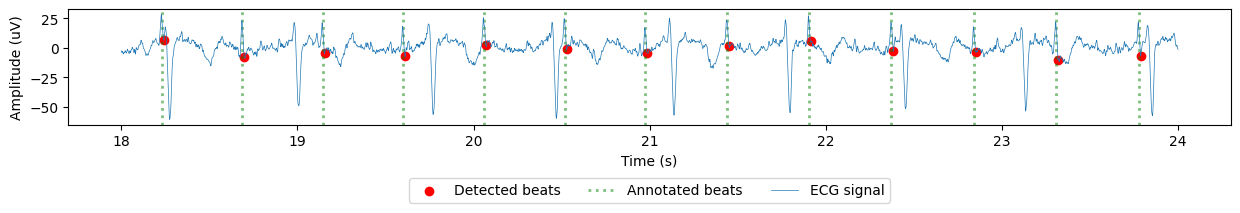

In [17]:
PEAKS_DISTANCE_FETUS = 0.325 # ~180 bpm
BEFORE_PEAK_FETUS = 0.05
AFTER_PEAK_FETUS = 0.05

fetus_peaks = qrs_detection(fecgs,UP_Fs,PEAKS_DISTANCE_FETUS,BEFORE_PEAK_FETUS,AFTER_PEAK_FETUS)

plot_signal_annotations(ecgs[0],fetus_peaks,UP_Fs,3,10,f_annot_scaled)

The algorithm implementation is now completed. We can pack all the previous steps in one final function (`apply_algorithm`) that will take the 4 ECGs and the annotations as input and will return an array with the fetus peaks and the scaled annotations (upsampled and delayed). 

In [18]:
def apply_algorithm(ecgs_raw,fecg_annot):
    '''
    This function will apply the whole algorithm to the signal (using the constants we declared before). It will also remove the first N
    beats from the annotations (given that they couldn't be detected).
    Input: the 4 ECGs and the annotations
    Output: the detected fetus peaks and the upscaled annotations
    '''
    ecgs, f_annot_scaled = preprocess_signals(ecgs_raw,fecg_annot)
    # Detect and remove mother beats
    mother_peaks = qrs_detection(ecgs,UP_Fs,PEAKS_DISTANCE_MOTHER,BEFORE_PEAK_MOTHER,AFTER_PEAK_MOTHER)
    fecgs, _ , start_at = mecg_removal(ecgs,mother_peaks,N_AVERAGE,UP_Fs,P_WAVE,T_WAVE)
    # Detect fetal QRS
    fetus_peaks = qrs_detection(fecgs,UP_Fs,PEAKS_DISTANCE_FETUS,BEFORE_PEAK_FETUS,AFTER_PEAK_FETUS)
    f_annot_scaled_new = []
    for f in f_annot_scaled:
        if f > start_at:
            f_annot_scaled_new.append(f)
    return [fetus_peaks,np.array(f_annot_scaled_new)]

Now we can apply the algorithm to the entire dataset. Here is a recap of the pipeline. For each dataset entry we will:

1. Load the dataset entry and remove unnecessary columns with `load_dataset_entry`. Then we preprocess the entry with the function `preprocess_signals` that:
    - `interpolate_nan_values`
    - `apply_hp_filter`
    - `remove_power_line_noise`
    - `upsample_signal`
2. Apply the algorithm to the entry using `apply_algorithm` function that:
    - Performs the qrs detection on the ecgs using the function `qrs_detection` that:
        - Applies the PCA on the signals: `do_PCA`
        - Find peaks on the result of the PCA
        - Creates a template of the peaks `create_template`
        - Find the qrs position by calculating the correlation of the signal with the template
    - Removes the maternal beat using the function `mecg_removal` that does:
        - Creates a template averaging the N previous qrss with `create_template`
        - Calculate the M matrix
        - Calculate the scaling vector a
        - Calculate qrs estimate
        - Removes the estimate from the signal
    - Detects the fetal ECG using `qrs_detection` on the and generate the fhr trace with `get_fhr_trace`.

At the end we will have the array `algorithm_results` that is a table where every row represent a dataset entry (be careful: the dataset entry ID is 1 + the index of the array because the numbering starts from 1). For each row we have two arrays: the first one contains all the detected peaks positions, the second one contains the annotated peaks positions (upscaled to the new Fs).

In [19]:
sample_ids = []
for file in os.listdir(DATA_FOLDER):
    if file.endswith(".csv"):
        # samples are named aXX.csv and we use only the XX as ID
        sample_ids.append(int(file[1:3]))
algorithm_results = []

for id in sample_ids:
    # Load and preprocess dataset entry
    ecgs_raw, fecg_annot = load_dataset_entry(id)
    # Apply algorithm to this entry and append results to the main results array
    algorithm_results.append(apply_algorithm(ecgs_raw,fecg_annot))

Now we can evaluate the performance of the algorithm. We will answer to two key questions:
- How good is the algorithm in the fetal beat detection task?
- How good is the FHR trace produced by the algorithm?

We can start from the first problem: the accuracy of the beat detection. Our question is: how many fetal beats are correctly detected? We define a window and then, for each annotated beat, we search for the nearest detected beat. We then calculate the distance: if it is inside the choosen window, we consider the beat as correctly detected. We do that for a bunch of window lengths and we extract the results and some useful metrics (detection rate, RMSE, mean, standard deviation). We will store all results in the `detection_evaluation_data` array which contains one row for every window length we tested. Each row is an array that contains the result stats ([sample_id, win_size, n_of_beats,matches,percent,rmse,mean,stdev]) for each sample of the dataset.

While we do this, we can also plot the error timeline for a particular dataset entry (or a specific window). In this example we plot the error timeline for the example and window size of 40ms

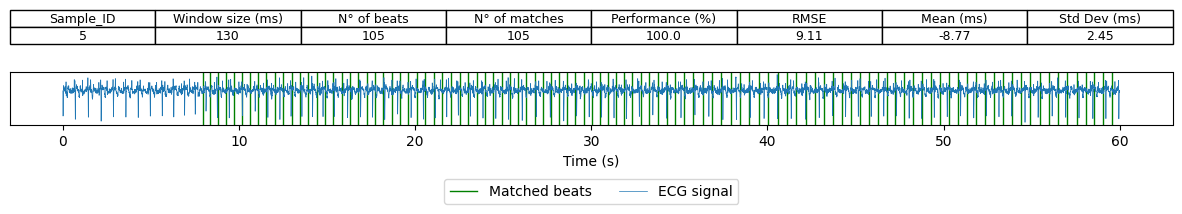

In [20]:
def evaluate_detection(detected_beats,annotated_beats,window_max_ms,fs):
    '''
    This function will evaluate the detection accuracy given the window size
    Input: positions of the detected beats, real position of the beats, window size, sampling freq
    Output: an array with two elements: the first is the array of the stats and the second is the array of missed beats.
    So the result has this form:
    [ 
        [ beats , matched_beats, % , rmse , mean , stdev ]
        , 
        array_of_missed_beats 
    ]
    '''
    matches = 0
    squared_error = 0
    distances = []
    distances_without_nones = []
    window_max_samples = (window_max_ms/1000) * fs
    for beat in annotated_beats:
        #find nearest detected peak
        idx = np.searchsorted(detected_beats, beat)
        if idx >= len(detected_beats):
            break
        elif idx > 0 and (abs(beat - detected_beats[idx-1]) < abs(beat - detected_beats[idx])):
            idx = idx - 1
        distance = detected_beats[idx] - beat
        if abs(distance) > window_max_samples: # if no match inside window (before and after)
            distances.append(None)
        else:
            distances.append(distance)
            distances_without_nones.append(distance)
            matches += 1
            squared_error += pow(distance,2)
    if matches > 0:
        rmse = math.sqrt(squared_error / matches)
        mean = np.mean(distances_without_nones)
        stdev = np.std(distances_without_nones)
    else:
        rmse = np.nan
        mean = np.nan
        stdev = np.nan
    percent = round((matches/len(distances))*100,1)
    # create array of missed beats
    missed_beats = [i for i,v in enumerate(distances) if v == None]
    return [len(distances),matches,percent,round(rmse,2),round(mean,2),round(stdev,2)],missed_beats

# Define the array of window lengths. It goes from 10ms to 130ms (with steps of 10ms) 
window_sizes_ms = list(range(10,140,10))

detection_evaluation_data = []

for i,win_size in enumerate(window_sizes_ms): # For every window size i
    results_for_size_w = []
    for j,alg_res in enumerate(algorithm_results): # For every dataset entry j
        res, missed_beats = evaluate_detection(alg_res[0],alg_res[1],win_size,UP_Fs)
        results_for_size_w.append([j] + [win_size] + res)

        # Print the timeline for the example dataset entry and window size of 60 ms
        samples_to_print = [EXAMPLE_N]
        if j+1 in samples_to_print and win_size == 130:
            raw_sig, raw_ann = load_dataset_entry(j+1)
            proc_sig, _ = preprocess_signals(raw_sig,raw_ann)
            plot_error_timeline(proc_sig[0],alg_res[1],UP_Fs,[j+1]+[win_size]+res,alg_res[1][missed_beats])
    detection_evaluation_data.append(results_for_size_w)

We can now plot the mean, std, max and mean accuracy based on the choosen window size:

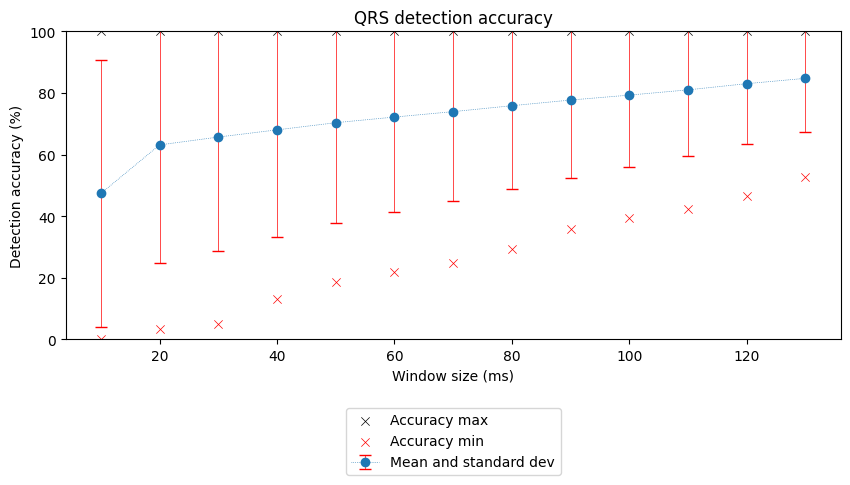

In [21]:
y_mean = []
y_std = []
y_min = []
y_max = []
for i in range(0,len(detection_evaluation_data)):
    y_mean.append(np.mean(np.array(detection_evaluation_data[i])[:,4]))
    y_std.append(np.std(np.array(detection_evaluation_data[i])[:,4]))
    y_min.append(np.min(np.array(detection_evaluation_data[i])[:,4]))
    y_max.append(np.max(np.array(detection_evaluation_data[i])[:,4]))

plt.rcParams['figure.figsize'] = [PLOT_WIDTH, 4]
plt.title("QRS detection accuracy")
plt.ylim([0,100])
plt.scatter(window_sizes_ms,y_max,marker="x",color="black",label="Accuracy max")
plt.scatter(window_sizes_ms,y_min,marker="x",color="r",label="Accuracy min")
plt.errorbar(window_sizes_ms, y_mean, y_std, linestyle=':', marker='o',ecolor='red',capsize=4,label="Mean and standard dev")

plt.ylabel("Detection accuracy (%)")
plt.xlabel("Window size (ms)")
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.2),fancybox=True)
plt.show()

As we can expect, the accuracy becomes higher with higher window sizes. However there is a big variability among the algorithm results for a given window size. We can also print a table with the results for each dataset entry at a given window size to do further inspections (we only print one of them here).

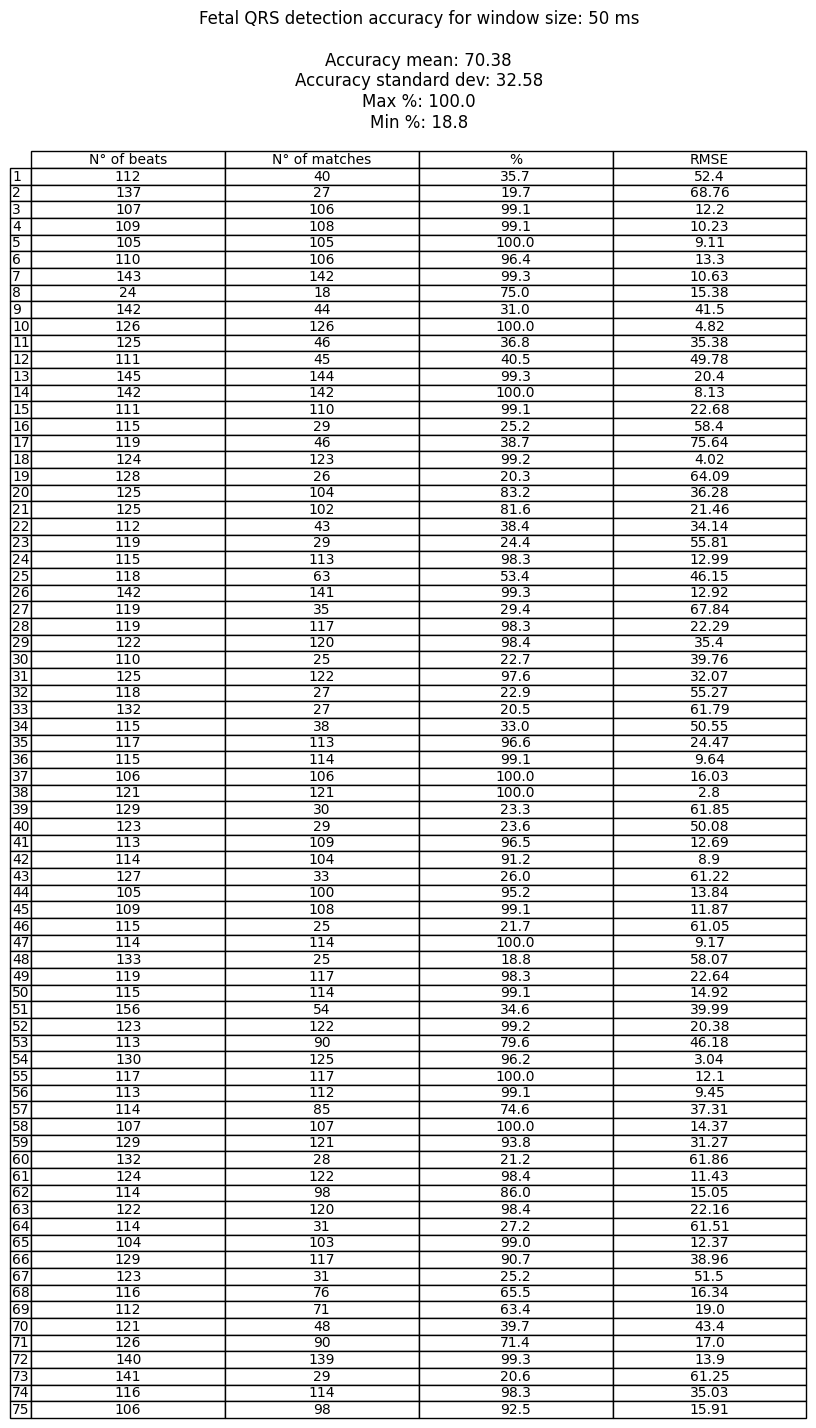

In [22]:
requested_win_sizes_indexes = [4] # Choose the window size you need by adding its index in here

for index in requested_win_sizes_indexes:
    detection_results = detection_evaluation_data[index]
    result_to_print = []
    for i in range(0,len(detection_results)):
        result_to_print.append([
            detection_results[i][2],
            round(detection_results[i][3],2),
            round(detection_results[i][4],2),
            round(detection_results[i][5],2)]
        )
    # Calculate stats for the accuracy % (column 4)
    performance_mean = np.mean(np.array(detection_results)[:,4])
    performance_std = np.std(np.array(detection_results)[:,4])
    max_perc = np.max(np.array(detection_results)[:,4])
    min_perc = np.min(np.array(detection_results)[:,4])
    plt.rcParams['figure.figsize'] = [PLOT_WIDTH, 0.2]
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('tight')
    title = "Fetal QRS detection accuracy for window size: " + str(window_sizes_ms[index]) + " ms\n"
    title = title + "\nAccuracy mean: " + str(round(performance_mean,2))
    title += "\nAccuracy standard dev: " + str(round(performance_std,2))
    title += "\nMax %: " + str(round(max_perc,2))
    title += "\nMin %: " + str(round(min_perc,2))
    ax.set_title(title)
    ax.table(cellText=result_to_print,
                    rowLabels=range(1,len(result_to_print)+1), 
                    colLabels=['N° of beats','N° of matches', '%','RMSE', 'Mean', 'Std Dev'],
                    cellLoc='center')
    plt.show()

Now we can move to the second question: the quality of the FHR trace.
We will write a function to get the FHR trace from a list of beat positions. We will use it to get the FHR for the detected beat and for the annotated beats. We can then do a comparison and evaluate how much the former deviates from the latter. We can also choose a value that represent the maximum allowed deviation and check when the trace is out of the acceptable range. For a given signal (here we will use the example signal), the plot will show the detected FHR trace, the real FHR trace and the zones when the difference between the two is too high.

In [23]:
def get_fhr_trace(peaks,sig_length,fs):
    '''
    This function builds a FHR trace (a signal that has the length of the original signal
    and shows, for each sample, the last detected Bpm)
    Input: the peaks positions, the signal length, the sampling freq
    Output: a signal that at each sample position has the last bpm detected by the algorithm
    '''
    trace = np.zeros(sig_length)
    for i in range(1,len(peaks)):
        interval_samples = peaks[i] - peaks[i-1]
        interval_sec = interval_samples / fs
        bpm = 60/interval_sec
        trace[peaks[i-1]:peaks[i]] += bpm
        if i == 1:
            a = 3
            #trace[0:peaks[i-1]] += bpm
        elif i == len(peaks)-1:
            trace[peaks[i]:] += bpm
    return trace

def evaluate_fhr_trace(trace, gt_trace, bpm_range):
    '''
    This function evaluates the goodness of the detected FHR trace, given the real FHR trace
    It also checks where the detected FHR goes beyond the maximum allowed range
    Input: the detected FHR trace, the real FHR trace, the maximum allowed bpm range
    Output: rmse, maximum error, % of FHR out of range, positions where the FHR is oor (boolean array) 
    '''
    rmse = root_mean_squared_error(gt_trace, trace)
    max_err = max_error(gt_trace, trace)
    fhr_trace_err_length = abs(trace - gt_trace) > bpm_range
    oor_perc = sum(fhr_trace_err_length) / len(fhr_trace_err_length) * 100
    return rmse, max_err, oor_perc, fhr_trace_err_length

BPM_MAX_RANGE = 10

We can now evaluate the performance of the FHR tracing on the whole dataset and print the results.

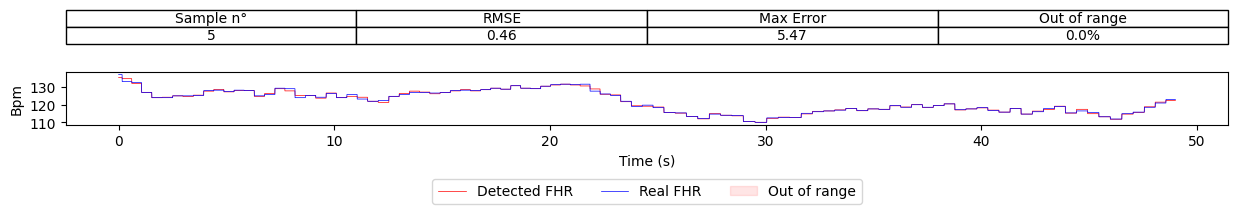

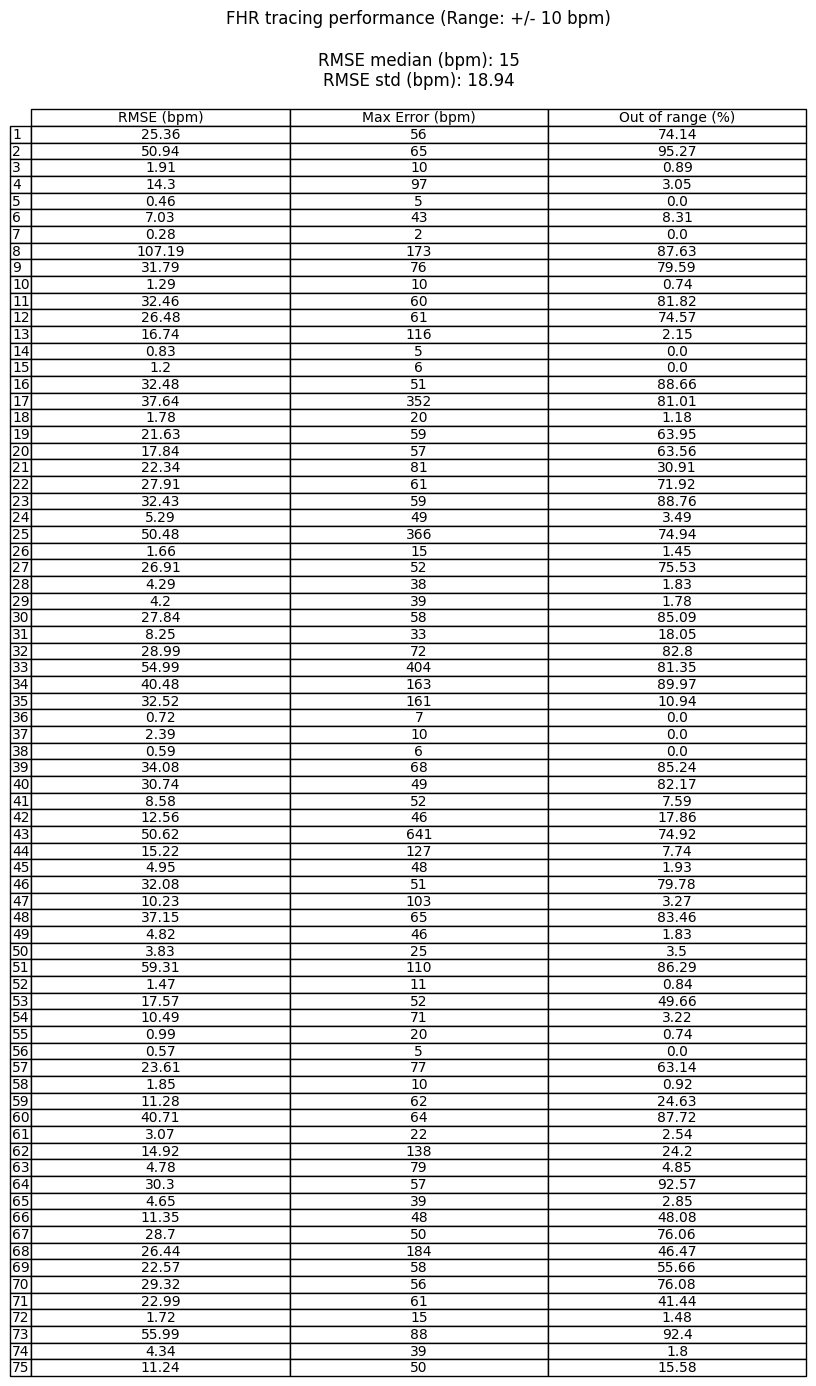

In [24]:
trace_results = []
trace_to_print = [EXAMPLE_N]
for i,ar in enumerate(algorithm_results):
    # Generate FHR trace and evaluate it
    fhr_trace = get_fhr_trace(ar[0],len(ecgs[0]),UP_Fs)
    fhr_trace_real = get_fhr_trace(ar[1],len(ecgs[0]),UP_Fs)
    # Remove the first and the last tracings
    fhr_trace = fhr_trace[20000:-2000]
    fhr_trace_real = fhr_trace_real[20000:-2000]
    fhr_rmse, fhr_max_er, fhr_oor_perc, fhr_trace_err_length = evaluate_fhr_trace(fhr_trace,fhr_trace_real,BPM_MAX_RANGE)
    trace_results.append([fhr_rmse, fhr_max_er, fhr_oor_perc])
    if i+1 in trace_to_print:
        plot_fhr_trace(fhr_trace,fhr_trace_real,fhr_trace_err_length,UP_Fs,[EXAMPLE_N,fhr_rmse,fhr_max_er,fhr_oor_perc])

# print all the stats
result_to_print = []
for i in range(0,len(trace_results)):
    result_to_print.append([round(trace_results[i][0],2),round(trace_results[i][1]),round(trace_results[i][2],2)])

# calculate global stats
fhr_tracing_rmse_median = round(np.median(np.array(trace_results)[:,0]))
fhr_tracing_max_err = round(np.max(np.array(trace_results)[:,1]),2)
fhr_tracing_std = round(np.std(np.array(trace_results)[:,0]),2)

plt.rcParams['figure.figsize'] = [PLOT_WIDTH, 0.2]

fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
title = "FHR tracing performance (Range: +/- " + str(BPM_MAX_RANGE) + " bpm)\n"
title = title + "\nRMSE median (bpm): " + str(fhr_tracing_rmse_median)
title += "\nRMSE std (bpm): " + str(fhr_tracing_std)

ax.set_title(title)
ax.table(cellText=result_to_print,
                rowLabels=range(1,len(result_to_print)+1), 
                colLabels=['RMSE (bpm)','Max Error (bpm)', 'Out of range (%)'],
                cellLoc='center')
plt.show()